In [1]:
# Gain modulation RNN, only BP, no synaptic learning
import numpy as np
import sys
sys.path.append("..")
from rnn_basic import RNN
import matplotlib.pyplot as plt
import json
import torch

## Loading Trained Weights

In [2]:
with open('../weights/MG_bpgain_128_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses'])

In [4]:
gain = np.array(weight_history['trained gain'])
shift = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
num_nodes = 128
init_activation = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activation, gain, shift, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

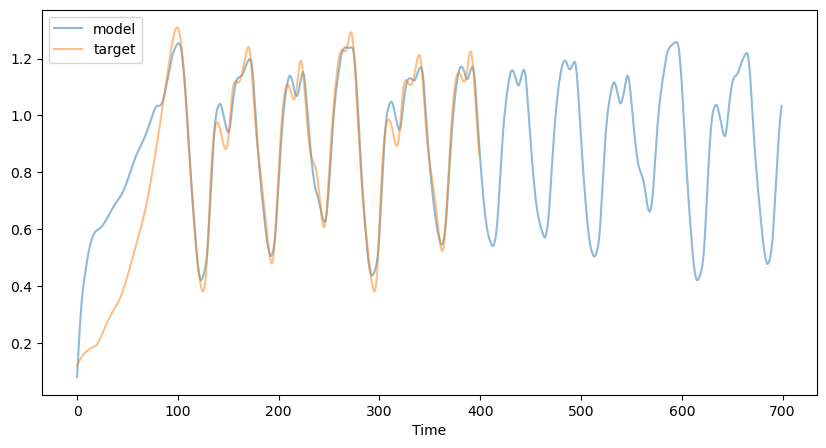

In [6]:
# Defining Inputs and Targets
def generate_MackeyGlass(ntimes, tau):
    # initial condition
    # x_values = np.random.uniform(0,1,tau).tolist()
    x_values = [0.1]*tau

    def mackey_glass(x, tau, gamma=0.1, beta0=0.2, n=10):
        dxdt = beta0 * x[-tau] / (1 + x[-tau]**n) - gamma * x[-1]
        return dxdt

    x_t = x_values[-1]
    for t in range(ntimes):
        dxdt = mackey_glass(x_values, tau)
        x_t = x_t + dxdt
        x_values.append(x_t)

    x = x_values[tau:]
    return x

total_time_steps = 700
time = total_time_steps * timestep
tau = 20
MG_sequence = np.array(generate_MackeyGlass(total_time_steps+1, tau))
inputs = MG_sequence[0:total_time_steps].reshape(-1,1)
targets = MG_sequence[1:401].reshape(-1,1)
outputs, activations = network.simulate(time, torch.tensor(inputs).float())

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(np.arange(total_time_steps), outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(np.arange(len(targets)), targets, alpha=0.5, label='target')
plt.xlabel('Time')
plt.legend()
plt.savefig("fig/1016_MG_bpgain_output.png")

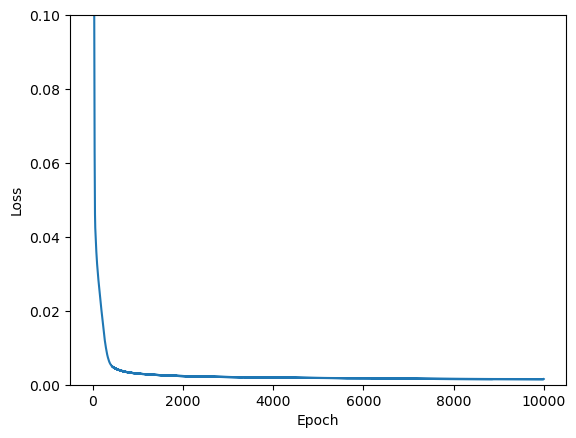

In [7]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0,0.1])
plt.savefig("fig/1016_MG_bpgain_loss.png")